In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Data generation
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Chains and Gibbs samples
C, G = 2, 10000
theta = np.zeros([C, G])  
tau = np.zeros([C, G])    

# Initialization
theta[:, 0] = np.mean(x)  
tau[:, 0] = 1 / np.var(x)  

# Prior hyperparameters
theta0 = 0      # Prior mean for theta
tau0 = 1        # Prior precision for theta
alpha = 2       # Shape parameter for Gamma prior on tau
lam = 1         # Rate parameter for Gamma prior on tau

# Proposal standard deviations
prop_sd_theta = 0.5  
prop_sd_tau = 0.5   

# Define the joint posterior 
joint_posterior = lambda theta, tau: (tau**(n/2) * np.exp(-0.5 * tau * np.sum((x - theta)**2)) *
                                      np.exp(-0.5 * tau0 * (theta - theta0)**2) *
                                      tau**(alpha - 1) * np.exp(-lam * tau))

# Metropolis-Hastings steps for theta and tau
for c in range(C):  
    for g in range(1, G):  

        # Metropolis update for theta
        theta_proposed = np.random.normal(theta[c, g-1], prop_sd_theta)
        p_current_theta = joint_posterior(theta[c, g-1], tau[c, g-1])
        p_proposed_theta = joint_posterior(theta_proposed, tau[c, g-1])
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta[c, g] = theta_proposed  # Accept
        else:
            theta[c, g] = theta[c, g-1]  # Reject
        

        # Metropolis update for tau

        tau_proposed = np.random.lognormal(np.log(tau[c, g-1]), prop_sd_tau)
        
        p_current_tau = joint_posterior(theta[c, g], tau[c, g-1])
        p_proposed_tau = joint_posterior(theta[c, g], tau_proposed)
        
        # Proposal ratio 
        proposal_ratio_tau = (stats.lognorm.pdf(tau[c, g-1], s=prop_sd_tau, scale=np.exp(np.log(tau_proposed))) /
                              stats.lognorm.pdf(tau_proposed, s=prop_sd_tau, scale=np.exp(np.log(tau[c, g-1]))))
        
        acceptance_ratio_tau = (p_proposed_tau / p_current_tau) * proposal_ratio_tau
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau[c, g] = tau_proposed  # Accept
        else:
            tau[c, g] = tau[c, g-1]  # Reject

# Burn-in and summary statistics
burn_in = 2000
theta_samples = theta[:, burn_in:].flatten()
tau_samples = tau[:, burn_in:].flatten()

print("Theta samples:", np.mean(theta_samples), np.std(theta_samples))
print("Tau samples:", np.mean(tau_samples), np.std(tau_samples))

Theta samples: 0.2952812848748018 0.21093280688909838
Tau samples: 0.7412593238275588 0.18286923930977542


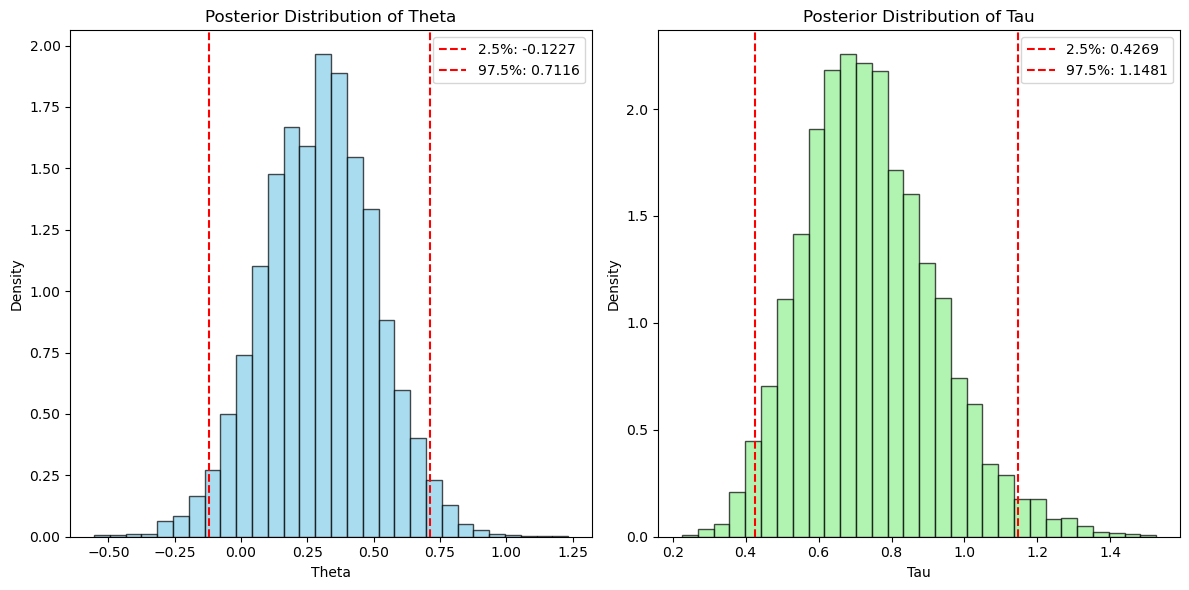

In [2]:
theta_all_samples = theta_samples.flatten()
tau_all_samples = tau_samples.flatten()

# Compute 95% credible intervals
theta_ci = np.percentile(theta_all_samples, [2.5, 97.5])
tau_ci = np.percentile(tau_all_samples, [2.5, 97.5])


plt.figure(figsize=(12, 6))

# Theta histogram
plt.subplot(1, 2, 1)
plt.hist(theta_all_samples, bins=30, color='skyblue', edgecolor='black', density=True, alpha=0.7)
plt.axvline(theta_ci[0], color='red', linestyle='--', label=f'2.5%: {theta_ci[0]:.4f}')
plt.axvline(theta_ci[1], color='red', linestyle='--', label=f'97.5%: {theta_ci[1]:.4f}')
plt.title('Posterior Distribution of Theta')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.legend()

# Tau histogram
plt.subplot(1, 2, 2)
plt.hist(tau_all_samples, bins=30, color='lightgreen', edgecolor='black', density=True, alpha=0.7)
plt.axvline(tau_ci[0], color='red', linestyle='--', label=f'2.5%: {tau_ci[0]:.4f}')
plt.axvline(tau_ci[1], color='red', linestyle='--', label=f'97.5%: {tau_ci[1]:.4f}')
plt.title('Posterior Distribution of Tau')
plt.xlabel('Tau')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Comparing that to the gibb sampler from last week 

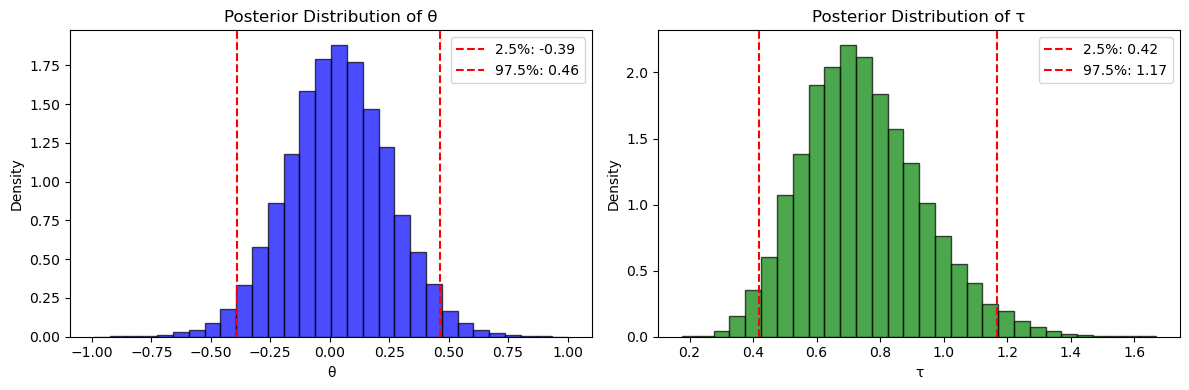

In [3]:
n = 30
m = 0  
s = 1  
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Gibbs 
C, G = 2, 10000 
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = 1000  
tau[:, 0] = 20
for c in range(C):
    for g in range(1, G):
        # τ | θ 
        sum_sq = ((x - theta[c, g-1])**2).sum()
        shape_tau = n / 2 + 1  
        rate_tau = sum_sq / 2
        tau[c, g] = stats.gamma(a=shape_tau, scale=1/rate_tau).rvs()  
        # θ | τ 
        theta_mean = x.mean()
        theta_std = 1 / np.sqrt(tau[c, g] * n)
        theta[c, g] = stats.norm(loc=theta_mean, scale=theta_std).rvs()

burn_in = 20  # Burn-in period
theta_post = theta[:, burn_in:].flatten()  # Flatten chains for θ
tau_post = tau[:, burn_in:].flatten()      # Flatten chains for τ

# Compute 95% credible intervals
theta_ci = np.percentile(theta_post, [2.5, 97.5])
tau_ci = np.percentile(tau_post, [2.5, 97.5])

# Plot histograms with credible intervals
fig, ax_hist = plt.subplots(1, 2, figsize=(12, 4))

# Histogram for θ
ax_hist[0].hist(theta_post, bins=30, color='blue',edgecolor = 'black', alpha=0.7, density=True)
ax_hist[0].axvline(theta_ci[0], color='red', linestyle='--', label=f'2.5%: {theta_ci[0]:.2f}')
ax_hist[0].axvline(theta_ci[1], color='red', linestyle='--', label=f'97.5%: {theta_ci[1]:.2f}')
ax_hist[0].set_title("Posterior Distribution of θ")
ax_hist[0].set_xlabel("θ")
ax_hist[0].set_ylabel("Density")
ax_hist[0].legend()

# Histogram for τ
ax_hist[1].hist(tau_post, bins=30, color='green',edgecolor = 'black', alpha=0.7, density=True)
ax_hist[1].axvline(tau_ci[0], color='red', linestyle='--', label=f'2.5%: {tau_ci[0]:.2f}')
ax_hist[1].axvline(tau_ci[1], color='red', linestyle='--', label=f'97.5%: {tau_ci[1]:.2f}')
ax_hist[1].set_title("Posterior Distribution of τ")
ax_hist[1].set_xlabel("τ")
ax_hist[1].set_ylabel("Density")
ax_hist[1].legend()

plt.tight_layout()
plt.show()

Between the two methods, the output for the credible interval of tau and theta aren't significantly different. We do see a slightly better estimate of theta to the mean, however both methods are reasonably accurate. However, this is due to the large sample size that we have produced. If the sample size were to be lower, then we'd see a faster convergence from the traditional gibb from the full conditional and vice versa, we'd see a wider credible interval from Metropolis hastings dwith a slower convergence. 

In [4]:
#Q2 truncnorm tau and laplace proposal for theta 

n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Chains and Gibbs samples
C, G = 2, 10000
theta = np.zeros([C, G])  
tau = np.zeros([C, G])    

# Initialization
theta[:, 0] = np.mean(x)  # Start with sample mean
tau[:, 0] = 1 / np.var(x)  # Start with inverse sample variance

# Prior hyperparameters
theta_loc = 0      # Location parameter for Laplace prior on theta
theta_scale = 1    # Scale parameter for Laplace prior on theta
alpha = 2          # Shape parameter for Gamma prior on tau
lam = 1            # Rate parameter for Gamma prior on tau

# Proposal standard deviations
prop_sd_theta = 0.5  # Proposal SD for theta
s = 0.5              # Scale parameter for truncated normal proposal for tau

# Define the joint posterior as a lambda function
joint_posterior = lambda theta, tau: (
    tau**(n/2) * np.exp(-0.5 * tau * np.sum((x - theta)**2)) *
    np.exp(-np.abs(theta - theta_loc) / theta_scale) *  # Laplace prior for theta
    tau**(alpha - 1) * np.exp(-lam * tau)               # Gamma prior for tau
)

# Metropolis-Hastings steps for theta and tau
for c in range(C):  
    for g in range(1, G):  
        #Metropolis update for theta

        theta_proposed = np.random.normal(theta[c, g-1], prop_sd_theta)
        p_current_theta = joint_posterior(theta[c, g-1], tau[c, g-1])
        p_proposed_theta = joint_posterior(theta_proposed, tau[c, g-1])
        
        acceptance_ratio_theta = p_proposed_theta / p_current_theta
        if np.random.rand() < min(1, acceptance_ratio_theta):
            theta[c, g] = theta_proposed  # Accept
        else:
            theta[c, g] = theta[c, g-1]  # Reject
        

        # Metropolis update for tau
        tau_t_minus_1 = tau[c, g-1]
        tau_proposed = stats.truncnorm.rvs(a=-tau_t_minus_1/s, b=np.inf,
                                           loc=tau_t_minus_1, scale=s)
        
        p_current_tau = joint_posterior(theta[c, g], tau[c, g-1])
        p_proposed_tau = joint_posterior(theta[c, g], tau_proposed)
        
        # No need for proposal ratio since truncnorm is symmetric
        acceptance_ratio_tau = p_proposed_tau / p_current_tau
        
        if np.random.rand() < min(1, acceptance_ratio_tau):
            tau[c, g] = tau_proposed  # Accept
        else:
            tau[c, g] = tau[c, g-1]  # Reject


Theta samples: 0.006619369261647124 0.1754446376641708
Theta 95% credible interval: [-0.34754066  0.36282322]
Tau samples: 1.004313036046019 0.2429225632311955
Tau 95% credible interval: [0.58705568 1.53884372]


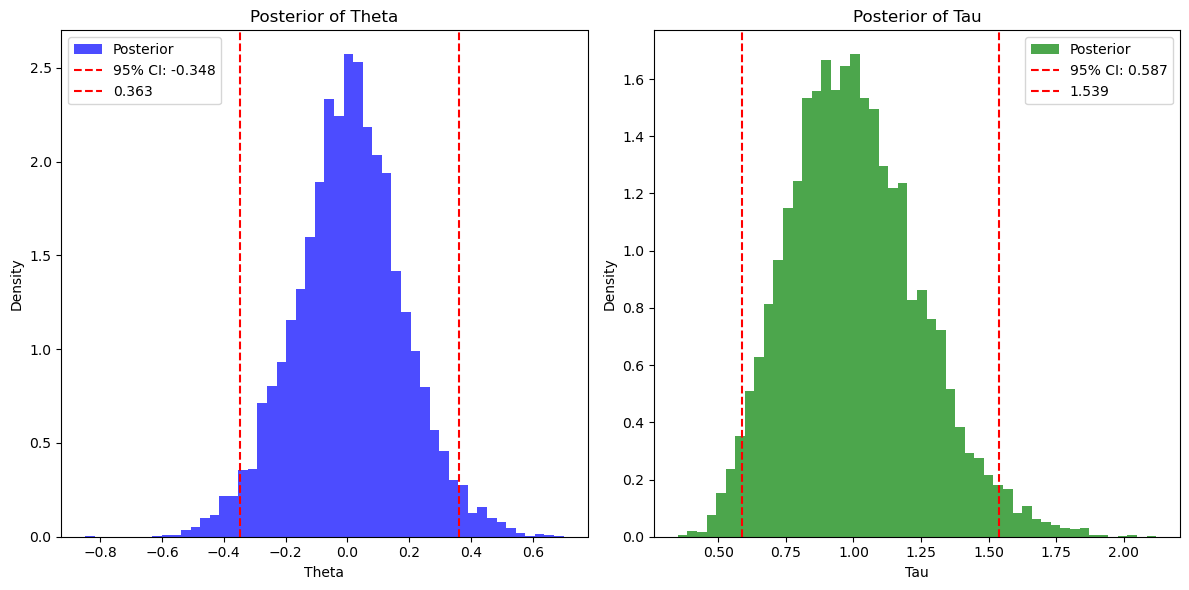

In [5]:
# Burn-in and summary statistics
burn_in = 2000
theta_samples = theta[:, burn_in:].flatten()
tau_samples = tau[:, burn_in:].flatten()

# Calculate 95% credible intervals
theta_ci = np.percentile(theta_samples, [2.5, 97.5])
tau_ci = np.percentile(tau_samples, [2.5, 97.5])

print("Theta samples:", np.mean(theta_samples), np.std(theta_samples))
print("Theta 95% credible interval:", theta_ci)
print("Tau samples:", np.mean(tau_samples), np.std(tau_samples))
print("Tau 95% credible interval:", tau_ci)

# Plot histograms of posterior samples with credible intervals
plt.figure(figsize=(12, 6))

# Theta histogram
plt.subplot(1, 2, 1)
plt.hist(theta_samples, bins=50, density=True, alpha=0.7, color='blue', label="Posterior")
plt.axvline(theta_ci[0], color='red', linestyle='--', label=f"95% CI: {theta_ci[0]:.3f}")
plt.axvline(theta_ci[1], color='red', linestyle='--', label=f"{theta_ci[1]:.3f}")
plt.title("Posterior of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()

# Tau histogram
plt.subplot(1, 2, 2)
plt.hist(tau_samples, bins=50, density=True, alpha=0.7, color='green', label="Posterior")
plt.axvline(tau_ci[0], color='red', linestyle='--', label=f"95% CI: {tau_ci[0]:.3f}")
plt.axvline(tau_ci[1], color='red', linestyle='--', label=f"{tau_ci[1]:.3f}")
plt.title("Posterior of Tau")
plt.xlabel("Tau")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

In Bayesian inference, Gibbs sampling relies on analytical full conditional distributions to sample from the posterior. When these conditionals are derivable, Gibbs sampling is highly efficient, as it avoids rejection steps and ensures rapid convergence. However, deriving full conditionals can be mathematically challenging or infeasible for complex models, especially when involving non-conjugate priors or non-standard likelihoods. In such cases, Metropolis-within-Gibbs sampling provides a flexible alternative by using Metropolis-Hastings updates for parameters without requiring explicit full conditionals. This approach sacrifices some efficiency due to rejection steps and the need for careful tuning of proposal distributions, it greatly expands the range of models that can be analyzed. Therefore, while analytical full conditionals are ideal for simplicity and computational speed, their absence does not hinder Bayesian inference, as Metropolis-within-Gibbs allows for practical and robust sampling even in complex models. The choice between these methods depends on the trade-off between model complexity and computational efficiency.

# Derivation of Transition Kernel for Metropolis-Hastings


We are given the following:

1. **Proposal Distribution $ q(\tilde{x} | x^{(t)}) $:**
   $$
   q(\tilde{x} | x^{(t)}) = 
   \begin{cases} 
   \frac{1}{2}, & \text{if } \tilde{x} = x^{(t)} \\
   \frac{1}{2}, & \text{if } \tilde{x} \neq x^{(t)}
   \end{cases}
   $$

2. **Stationary Distribution $ p(x) $:**
   $$
   p(x) = 
   \begin{cases} 
   \frac{1}{3}, & \text{if } x = 0 \\
   \frac{2}{3}, & \text{if } x = 1
   \end{cases}
   $$

3. **Acceptance Probability $ \alpha(x^{(t)}, \tilde{x}) $:**
   $$
   \alpha(x^{(t)}, \tilde{x}) = \min\left(1, \frac{p(\tilde{x}) \cdot q(x^{(t)} | \tilde{x})}{p(x^{(t)}) \cdot q(\tilde{x} | x^{(t)})}\right)
   $$

We want to derive the transition kernel \( K \) for the Markov chain defined by the Metropolis-Hastings algorithm.

---

## Transition Probability Matrix K 

The transition probabilities are calculated as:
$$
K_{x^{(t)} \to x^{(t+1)}} = q(x^{(t+1)} | x^{(t)}) \cdot \alpha(x^{(t)}, x^{(t+1)}) + \delta_{x^{(t)}, x^{(t+1)}} \cdot \left( 1 - \sum_{\tilde{x} \neq x^{(t)}} q(\tilde{x} | x^{(t)}) \cdot \alpha(x^{(t)}, \tilde{x}) \right),
$$
where $\delta_{x^{(t)}, x^{(t+1)}} $ is 1 if $ x^{(t)} = x^{(t+1)} $, and 0 otherwise.

---

### Case 1: $ x^{(t)} = 0 \to x^{(t+1)} = 1 $

1. Compute $ q(1 | 0) $:
   $$
   q(1 | 0) = \frac{1}{2}.
   $$

2. Compute $ \alpha(0, 1) $:
   $$
   \alpha(0, 1) = \min\left(1, \frac{p(1)}{p(0)}\right) = \min\left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right) = 1.
   $$

3. Transition probability:
   $$
   K_{0 \to 1} = q(1 | 0) \cdot \alpha(0, 1) = \frac{1}{2} \cdot 1 = 0.5.
   $$

---

### Case 2: $ x^{(t)} = 0 \to x^{(t+1)} = 0 $

1. Compute the self-transition probability:
   $$
   K_{0 \to 0} = 1 - K_{0 \to 1} = 1 - 0.5 = 0.5.
   $$

---

### Case 3: $ x^{(t)} = 1 \to x^{(t+1)} = 0 $

1. Compute $ q(0 | 1) $:
   $$
   q(0 | 1) = \frac{1}{2}.
   $$

2. Compute $ \alpha(1, 0) $:
   $$
   \alpha(1, 0) = \min\left(1, \frac{p(0)}{p(1)}\right) = \min\left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right) = \frac{1}{2}.
   $$

3. Transition probability:
   $$
   K_{1 \to 0} = q(0 | 1) \cdot \alpha(1, 0) = \frac{1}{2} \cdot \frac{1}{2} = 0.25.
   $$

---

### Case 4: $ x^{(t)} = 1 \to x^{(t+1)} = 1 $

1. Compute the self-transition probability:
   $$
   K_{1 \to 1} = 1 - K_{1 \to 0} = 1 - 0.25 = 0.75.
   $$

---

### Transition Kernel Matrix

Combining all cases, the transition kernel \( K \) is:
$$
K = \begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}.
$$